# Dropout 조절

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.


In [3]:
transform2 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
# 데이터셋 불러오기
nespresso_dataset = datasets.ImageFolder(root="./garbage_classification", transform=transform2)
# DataLoader를 사용하여 이미지 데이터를 배치 단위로 불러올 수 있음
nespresso_data_loader = torch.utils.data.DataLoader(nespresso_dataset, batch_size=1, shuffle=False)
# 이미지 데이터를 NumPy 배열로 변환하고 평균과 표준편차를 계산
pixel_values = []
for images, _ in nespresso_data_loader:
    pixel_values.append(images.numpy())
pixel_values = np.concatenate(pixel_values, axis=0)
# 픽셀 값의 평균과 표준편차 계산
mean = np.mean(pixel_values, axis=(0, 2, 3))
std = np.std(pixel_values, axis=(0, 2, 3))
print("평균:", mean)
print("표준편차:", std)

평균: [0.658015   0.61616427 0.5855862 ]
표준편차: [0.27152407 0.28306955 0.29741076]


In [4]:
# CIFAR10 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.6580, 0.6161, 0.5856], [0.2715, 0.2830, 0.2974]) # 알려진 CIFAR10의 평균과 표준편차
])

# 데이터셋 불러오기
garbage_dataset = datasets.ImageFolder(root="./garbage_classification", transform=transform)
# DataLoader를 사용하여 이미지 데이터를 배치 단위로 불러올 수 있음
garbage_loader = torch.utils.data.DataLoader(garbage_dataset, batch_size=1, shuffle=False)

total_size = len(garbage_dataset)

# 훈련 세트의 비율 설정
train_ratio = 0.8

# 훈련 세트와 테스트 세트로 나누기
train_size = int(train_ratio * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(garbage_dataset, [train_size, test_size])

# 훈련과 테스트 데이터로더 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [6]:
# 훈련 함수    
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)

In [7]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

## 1. Dropout 없음

In [8]:
class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg19 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)

    def forward(self, x):
        return self.vggnet(x)

In [9]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [10]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)

In [11]:
# batchsize 256, 128, lr: 0.0001
# vgg19
# optimizer: adam
# 훈련 및 테스트 실행
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.0770
Test loss: 2.0574, Accuracy: 39.14%
Epoch 2, Training loss: 2.2049
Test loss: 1.8958, Accuracy: 42.97%
Epoch 3, Training loss: 2.0653
Test loss: 1.8103, Accuracy: 42.78%
Epoch 4, Training loss: 1.9458
Test loss: 1.6894, Accuracy: 45.97%
Epoch 5, Training loss: 1.8121
Test loss: 1.6680, Accuracy: 47.58%
Epoch 6, Training loss: 1.7047
Test loss: 1.4978, Accuracy: 49.52%
Epoch 7, Training loss: 1.6115
Test loss: 1.4333, Accuracy: 52.80%
Epoch 8, Training loss: 1.5413
Test loss: 1.3878, Accuracy: 55.38%
Epoch 9, Training loss: 1.4754
Test loss: 1.4630, Accuracy: 51.68%
Epoch 10, Training loss: 1.4031
Test loss: 1.2679, Accuracy: 59.61%
Epoch 11, Training loss: 1.3388
Test loss: 1.2323, Accuracy: 60.22%
Epoch 12, Training loss: 1.2883
Test loss: 1.2916, Accuracy: 58.51%
Epoch 13, Training loss: 1.2661
Test loss: 1.3164, Accuracy: 57.54%
Epoch 14, Training loss: 1.2226
Test loss: 1.2011, Accuracy: 61.15%
Epoch 15, Training loss: 1.1984
Test loss: 1.1481, Accura

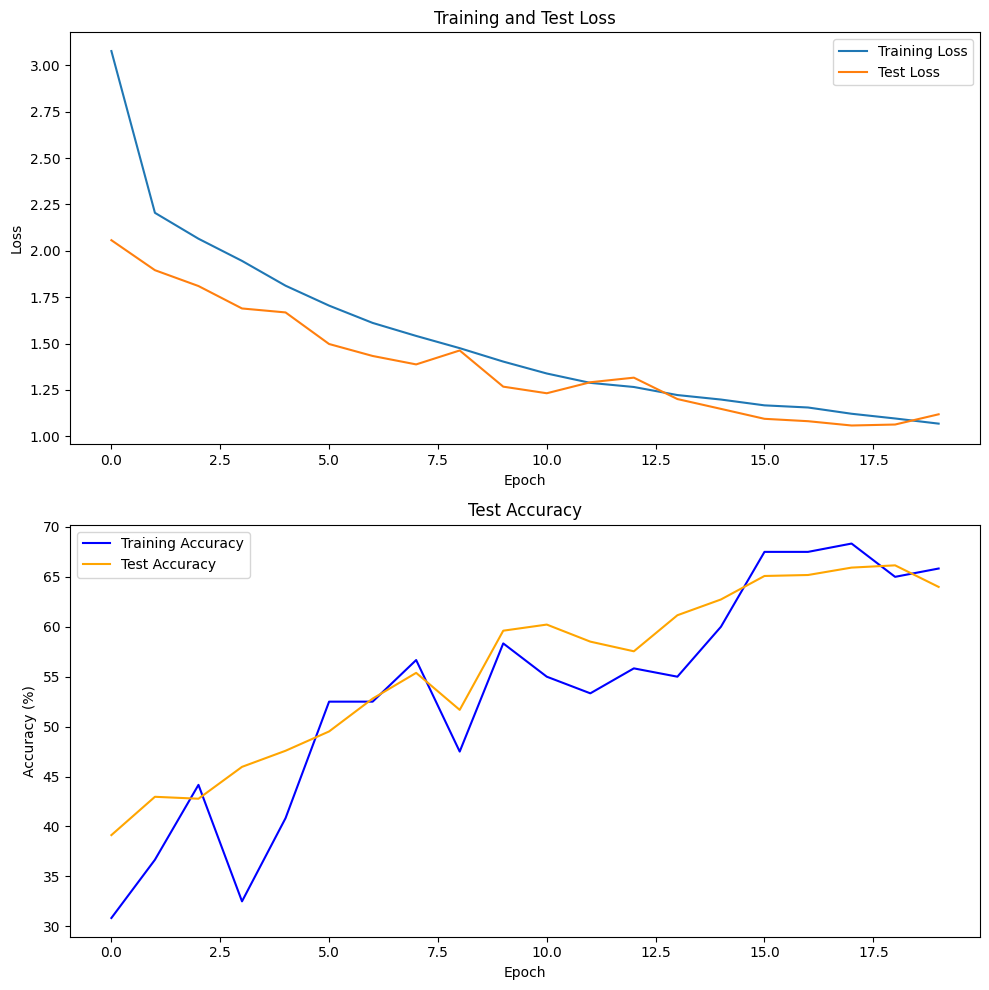

In [12]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

## 2. Dropout 0.5

In [13]:
class myVggNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(myVggNet, self).__init__()
        # vgg19 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.vggnet(x)
        # FC 레이어 출력에 드롭아웃 적용
        x = self.dropout(x)
        return x

In [14]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [15]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)

In [ ]:
# batchsize 256, 128, lr: 0.0001
# vgg19
# optimizer: adam
# 훈련 및 테스트 실행
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

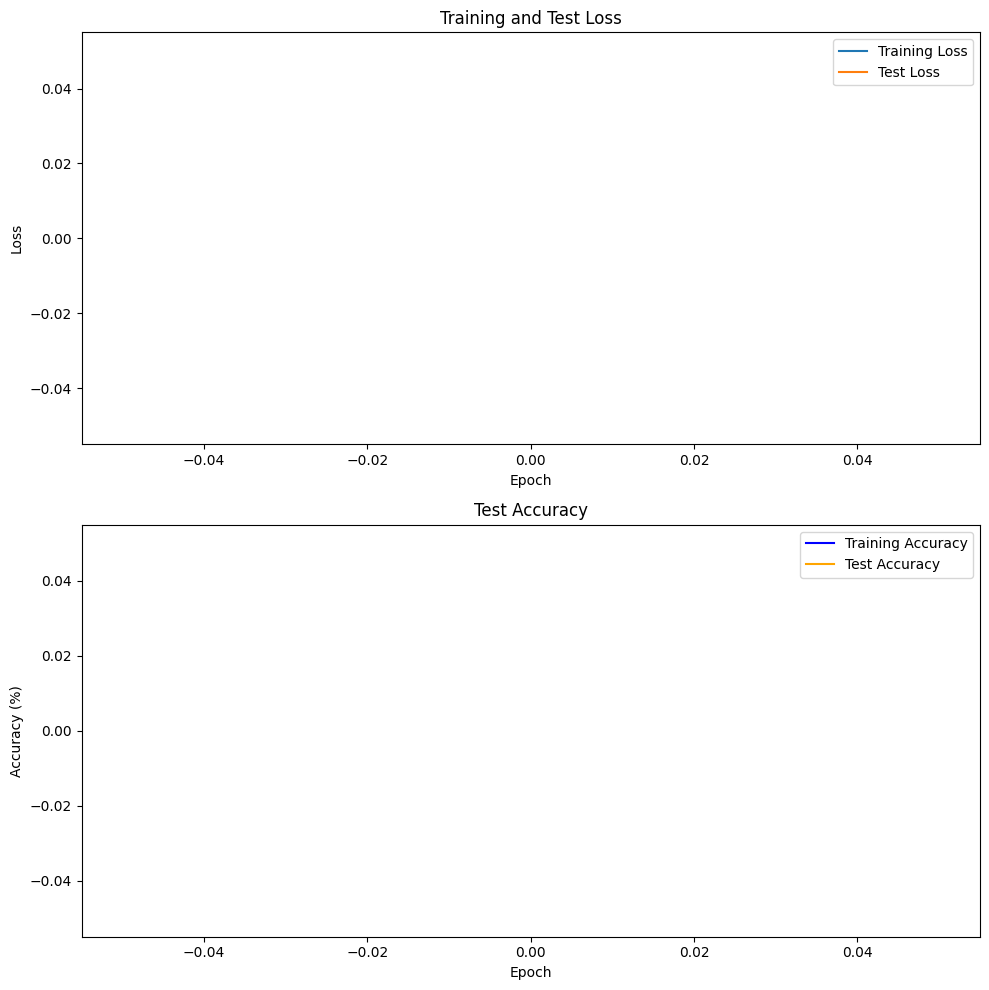

In [16]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

## 3. Dropout 0.3

In [17]:
class myVggNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(myVggNet, self).__init__()
        # vgg19 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.vggnet(x)
        # FC 레이어 출력에 드롭아웃 적용
        x = self.dropout(x)
        return x

In [18]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [19]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)

In [ ]:
# batchsize 256, 128, lr: 0.0001
# vgg19
# optimizer: adam
# 훈련 및 테스트 실행
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

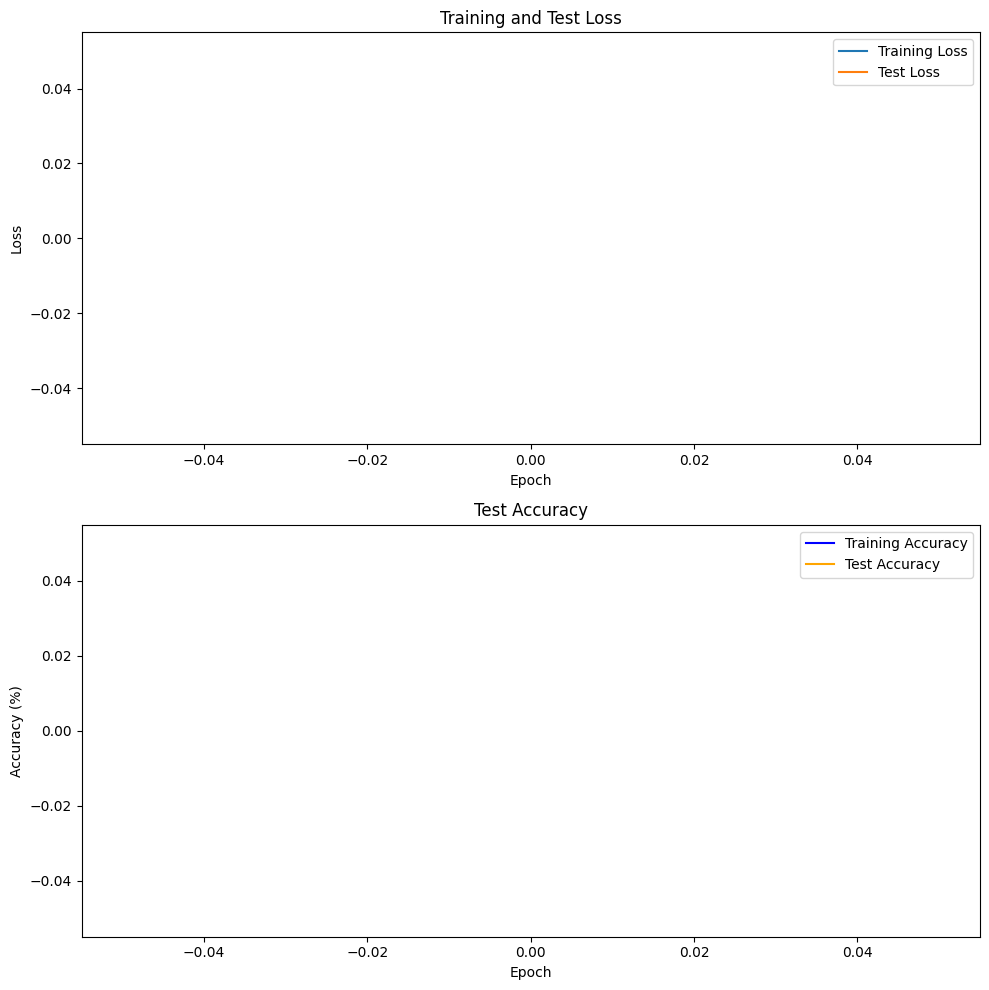

In [20]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

## 4. Dropout 0.4

In [21]:
class myVggNet(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(myVggNet, self).__init__()
        # vgg19 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.vggnet(x)
        # FC 레이어 출력에 드롭아웃 적용
        x = self.dropout(x)
        return x

In [22]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [23]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)

In [ ]:
# batchsize 256, 128, lr: 0.0001
# vgg19
# optimizer: adam
# 훈련 및 테스트 실행
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

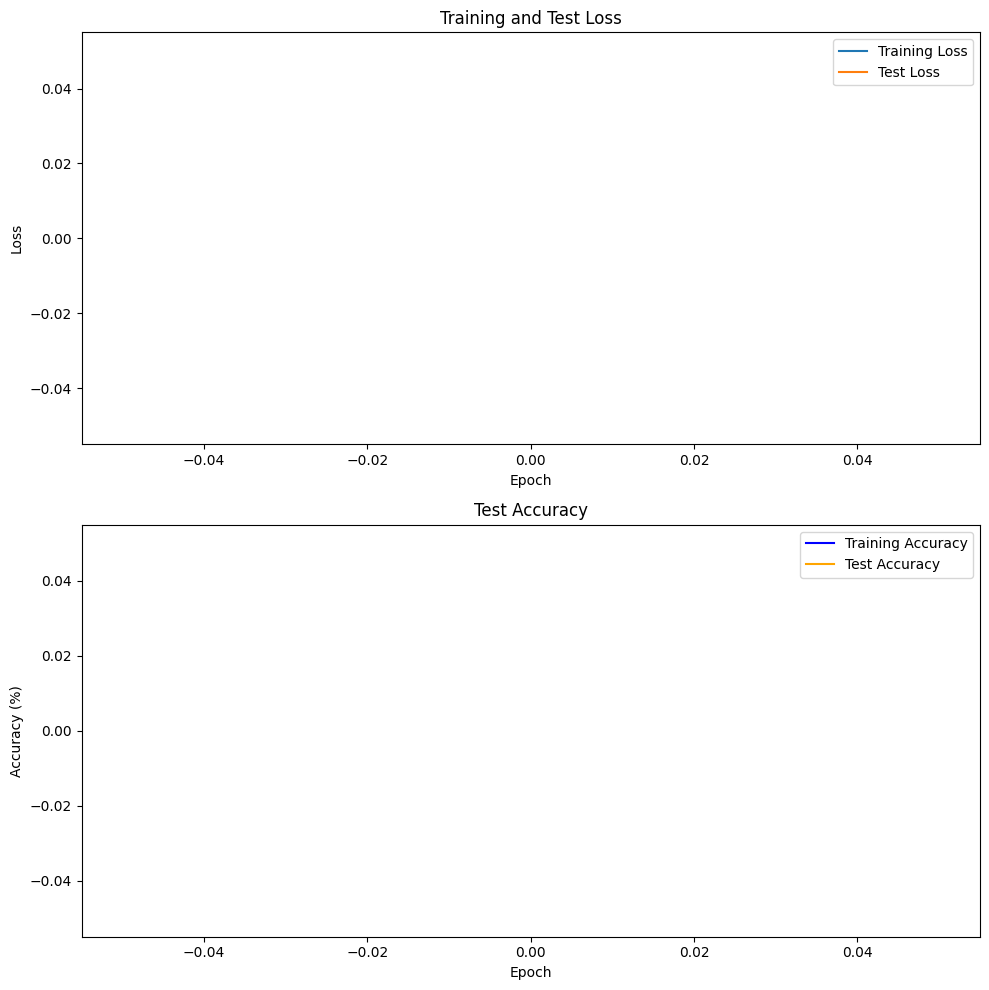

In [24]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

## 4. Dropout 0.6

In [25]:
class myVggNet(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super(myVggNet, self).__init__()
        # vgg19 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.vggnet(x)
        # FC 레이어 출력에 드롭아웃 적용
        x = self.dropout(x)
        return x

In [26]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [27]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)

In [ ]:
# batchsize 256, 128, lr: 0.0001
# vgg19
# optimizer: adam
# 훈련 및 테스트 실행
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

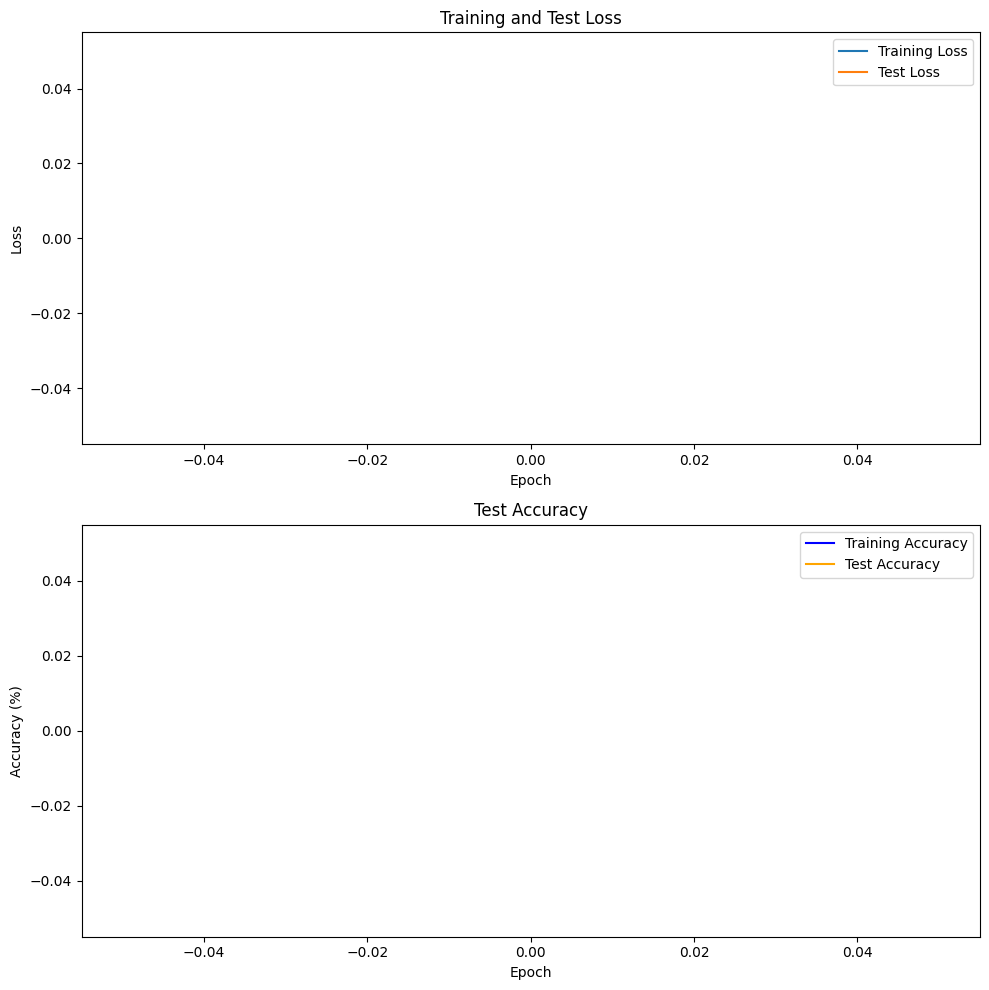

In [28]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

## 5. Dropout 0.7

In [29]:
class myVggNet(nn.Module):
    def __init__(self, dropout_rate=0.7):
        super(myVggNet, self).__init__()
        # vgg19 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.vggnet(x)
        # FC 레이어 출력에 드롭아웃 적용
        x = self.dropout(x)
        return x

In [30]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [31]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)

In [ ]:
# batchsize 256, 128, lr: 0.0001
# vgg19
# optimizer: adam
# 훈련 및 테스트 실행
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

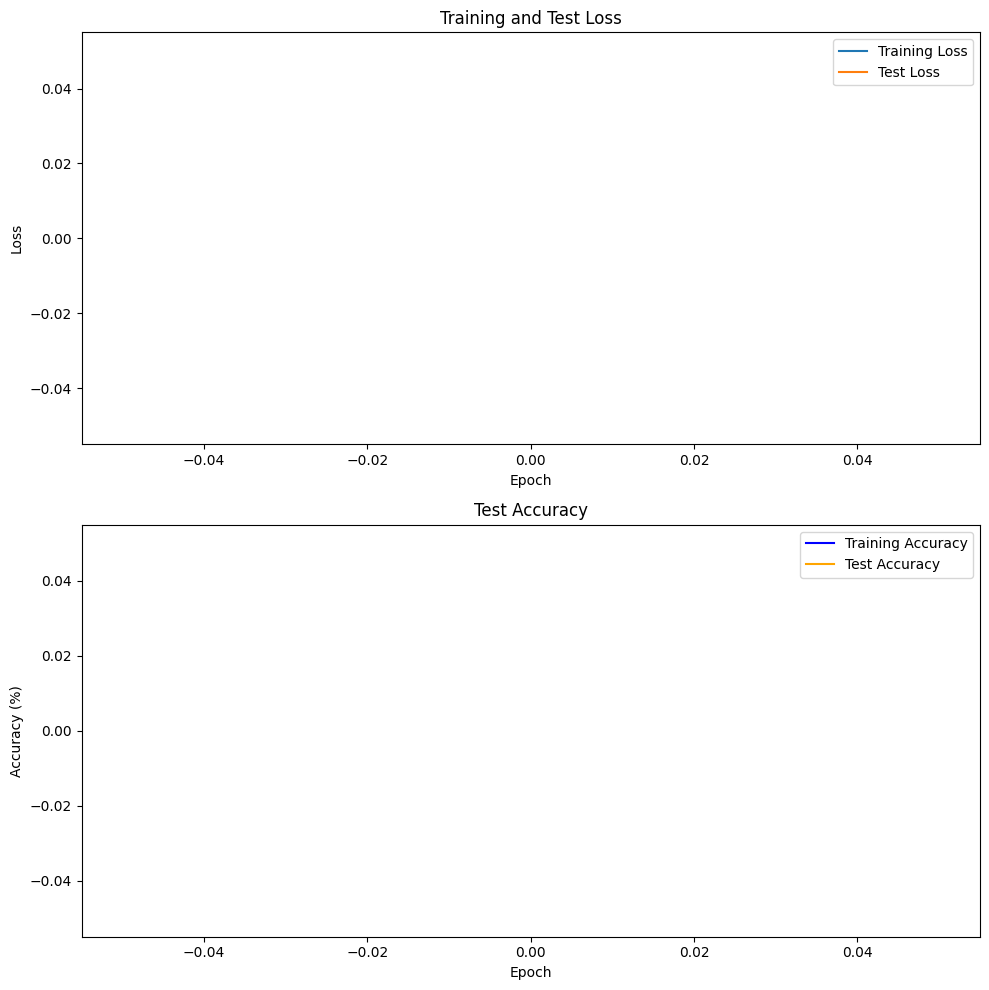

In [32]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()